# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [81]:
import pandas as pd
import numpy as np
import scipy

import string

import nltk
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# stopwords_eng = list(stopwords.words('english'))
# stopwords_eng.append('-PRON-')
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

import matplotlib.pyplot as plt

from gensim.models import Word2Vec, FastText

from math import log

In [ ]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'

In [ ]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.drop('review_id', axis=1, inplace=True)
df

,negative,positive,score
0,There were issues with the wifi connection,No Positive,7.1
1,TV not working,No Positive,7.5
2,More pillows,Beautiful room Great location Lovely staff,10.0
3,Very business,Location,5.4
4,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7
...,...,...,...
99995,No coffee facilities in room Air Con didn t s...,Very quiet for a central London Hotel Comfy b...,7.9
99996,The room was far too hot on the first night 2...,breakfast was fine welcome with cava was good,4.2
99997,Terrible worn out Mattress dust behind the he...,The well meaning staff,5.0
99998,No Negative,Very profissional and nice staff Very well de...,9.6


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [ ]:
def process_text(text):
    text = ' '.join([word for word in word_tokenize(text.lower()) if word not in string.punctuation])
    text = ' '.join([token.lemma_ for token in nlp(text)])
    
    return text

In [ ]:
%%time

df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)
df

Wall time: 5min 39s


,negative,positive,score
0,there be issue with the wifi connection,no positive,7.1
1,tv not work,no positive,7.5
2,more pillow,beautiful room great location lovely staff,10.0
3,very business,location,5.4
4,room could do with a bit of a refurbishment as...,nice breakfast handy for victoria train statio...,6.7
...,...,...,...
99995,no coffee facility in room air con didn t seem...,very quiet for a central london hotel comfy be...,7.9
99996,the room be far too hot on the first night 28 ...,breakfast be fine welcome with cava be good,4.2
99997,terrible wear out mattress dust behind the hea...,the well meaning staff,5.0
99998,no negative,very profissional and nice staff very well dec...,9.6


In [ ]:
df['negative'] = df['negative'].apply(lambda x: '' if x == 'no negative' else x)
df['positive'] = df['positive'].apply(lambda x: '' if x == 'no positive' else x)
df

,negative,positive,score
0,there be issue with the wifi connection,,7.1
1,tv not work,,7.5
2,more pillow,beautiful room great location lovely staff,10.0
3,very business,location,5.4
4,room could do with a bit of a refurbishment as...,nice breakfast handy for victoria train statio...,6.7
...,...,...,...
99995,no coffee facility in room air con didn t seem...,very quiet for a central london hotel comfy be...,7.9
99996,the room be far too hot on the first night 28 ...,breakfast be fine welcome with cava be good,4.2
99997,terrible wear out mattress dust behind the hea...,the well meaning staff,5.0
99998,,very profissional and nice staff very well dec...,9.6


In [ ]:
df['united'] = df['negative'] + ' ' + df['positive']

In [ ]:
df.to_csv('train_reviews.csv')

In [ ]:
df = pd.read_csv('train_reviews.csv', index_col=[0]).fillna('')

In [ ]:
df

,negative,positive,score,united
0,there be issue with the wifi connection,,7.1,there be issue with the wifi connection
1,tv not work,,7.5,tv not work
2,more pillow,beautiful room great location lovely staff,10.0,more pillow beautiful room great location love...
3,very business,location,5.4,very business location
4,room could do with a bit of a refurbishment as...,nice breakfast handy for victoria train statio...,6.7,room could do with a bit of a refurbishment as...
...,...,...,...,...
99995,no coffee facility in room air con didn t seem...,very quiet for a central london hotel comfy be...,7.9,no coffee facility in room air con didn t seem...
99996,the room be far too hot on the first night 28 ...,breakfast be fine welcome with cava be good,4.2,the room be far too hot on the first night 28 ...
99997,terrible wear out mattress dust behind the hea...,the well meaning staff,5.0,terrible wear out mattress dust behind the hea...
99998,,very profissional and nice staff very well dec...,9.6,very profissional and nice staff very well de...


In [ ]:
df_train, df_test = train_test_split(df, random_state=42)

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [ ]:
X_train, y_train = df_train.drop('score', axis=1), df_train['score']
X_test, y_test = df_test.drop('score', axis=1), df_test['score']

In [ ]:
df_train_separate = pd.concat([df_train['negative'], df_train['positive'], df_test['negative'], df_test['positive'], df_kaggle['negative'], df_kaggle['positive']], axis=0)
df_train_separate

98980    cup wash up each day -PRON- stay dirty all wee...
69824                              tiny but tidy cosy pool
9928                                                      
75599    the wall between the room be a bit thin -PRON-...
95621                                              nothing
                               ...                        
19995                                                     
19996    great location on the piccadilly line so easy ...
19997    great location very nice design great breakfas...
19998    the entrance area look great and the ground fl...
19999    -PRON- be big the staff be kind the food be go...
Length: 240000, dtype: object

In [ ]:
%%time

vec_united = TfidfVectorizer(ngram_range=(1, 2), stop_words=stopwords_eng)
vec_united = vec_united.fit(X_train['united'])

Wall time: 3.11 s


In [ ]:
%%time

vec_separate = TfidfVectorizer(ngram_range=(1, 2))
vec_separate = vec_separate.fit(df_train_separate)

Wall time: 2.4 s


In [ ]:
def get_bow_separate(df):
    bow_negative = vec_separate.transform(df['negative'])
    bow_positive = vec_separate.transform(df['positive'])
    bow = scipy.sparse.hstack([bow_negative, bow_positive])
    
    return bow


def get_bow_united(df):
    bow = vec_united.transform(df['united'])
    
    return bow

In [ ]:
%%time

# positive и negative части отзывов рассматриваются отдельно
lr_model = Ridge()
lr_model.fit(get_bow_separate(X_train), y_train)
print(mean_absolute_error(lr_model.predict(get_bow_separate(X_test)), y_test))

0.8331466708469388
Wall time: 2.66 s


In [ ]:
%%time

# positive и negative части отзывов рассматриваются отдельно
lr_model = GradientBoostingRegressor()
lr_model.fit(get_bow_separate(X_train), y_train)
print(mean_absolute_error(lr_model.predict(get_bow_separate(X_test)), y_test))

0.9002960588274448
Wall time: 3min 46s


In [ ]:
%%time

# positive и negative части отзывов объединены
lr_model = Ridge()
lr_model.fit(get_bow_united(X_train), y_train)
print(mean_absolute_error(lr_model.predict(get_bow_united(X_test)), y_test))

0.8985487394485128
Wall time: 4.14 s


### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [ ]:
w2v_model_united = Word2Vec(sentences=[x.split() for x in df_train['united']], size=300, window=10, workers=4)

In [ ]:
w2v_model_separate = Word2Vec(sentences=[x.split() for x in df_train_separate], size=300, window=10, workers=4)

In [ ]:
def get_embeddings_united(df, model_united, fasttext_model=False):
    def vectorize_sentence(text):
        text = text.split()
        vectorized = []
        for word in text:
            if word in model_united.wv:
                vectorized.append(model_united.wv[word])
            else:
                if fasttext_model:
                    vectorized.append(model_united.wv[model_separate.wv.most_similar(word)[0][0]])
        if not vectorized:
            vectorized = [np.zeros(model_united.wv.vector_size)]
        vectorized = np.array(vectorized)
        vectorized = np.sum(vectorized, axis=0)
        
        return vectorized

    embeddings_united = np.array([vectorize_sentence(x) for x in df['united']])
    
    return embeddings_united


def get_embeddings_separate(df, model_separate, fasttext_model=False):
    def vectorize_sentence(text):
        text = text.split()
        vectorized = []
        for word in text:
            if word in model_separate.wv:
                vectorized.append(model_separate.wv[word])
            else:
                if fasttext_model:
                    vectorized.append(model_separate.wv[model_separate.wv.most_similar(word)[0][0]])
        if not vectorized:
            vectorized = [np.zeros(model_separate.wv.vector_size)]
        vectorized = np.array(vectorized)
        vectorized = np.sum(vectorized, axis=0)

        return vectorized
    
    embeddings_negative = np.array([vectorize_sentence(x) for x in df['negative']])
    embeddings_positive = np.array([vectorize_sentence(x) for x in df['positive']])
    embeddings_separate = np.hstack([embeddings_negative, embeddings_positive])
    
    return embeddings_separate

In [ ]:
%%time

# positive и negative части отзывов объединены
lr_model = Ridge()
lr_model.fit(get_word2vec_united(X_train), y_train)
print(mean_absolute_error(lr_model.predict(get_word2vec_united(X_test)), y_test))

0.9905164540736063
Wall time: 6.05 s


In [ ]:
%%time

# positive и negative части отзывов рассматриваются отдельно
lr_model = Ridge()
lr_model.fit(get_embeddings_separate(X_train, w2v_model_separate), y_train)
print(mean_absolute_error(lr_model.predict(get_embeddings_separate(X_test, w2v_model_separate)), y_test))

0.9279350965053932
Wall time: 7.32 s


Wall time: 1min 58s


Text(0.5, 0, 'vector size')

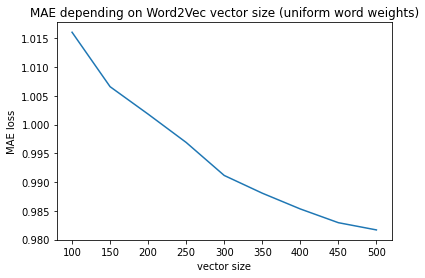

In [ ]:
%%time

# positive и negative части отзывов объединены
vector_size_range = list(range(100, 501, 50))
mae_log = []
for vector_size in vector_size_range:
    w2v_model_united = Word2Vec(sentences=[x.split() for x in df_train['united']], size=vector_size, window=10, workers=4)
    lr_model = Ridge()
    lr_model.fit(get_word2vec_united(X_train), y_train)
    mae = mean_absolute_error(lr_model.predict(get_word2vec_united(X_test)), y_test)
    mae_log.append(mae)

plt.plot(vector_size_range, mae_log)
plt.title('MAE depending on Word2Vec vector size (uniform word weights)')
plt.ylabel('MAE loss')
plt.xlabel('vector size');

Wall time: 2min 10s


Text(0.5, 0, 'vector size')

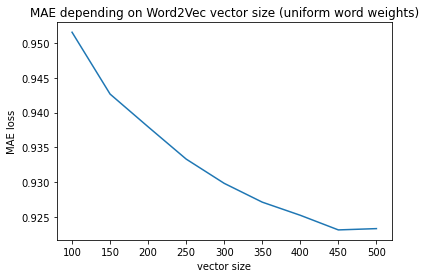

In [ ]:
%%time

# positive и negative части отзывов рассматриваются отдельно
vector_size_range = list(range(100, 501, 50))
mae_log = []
for vector_size in vector_size_range:
    w2v_model_separate = Word2Vec(sentences=[x.split() for x in df_train_separate], size=vector_size, window=10, workers=4)
    lr_model = Ridge()
    lr_model.fit(get_word2vec_separate(X_train), y_train)
    mae = mean_absolute_error(lr_model.predict(get_word2vec_separate(X_test)), y_test)
    mae_log.append(mae)

plt.plot(vector_size_range, mae_log)
plt.title('MAE depending on Word2Vec vector size (uniform word weights)')
plt.ylabel('MAE loss')
plt.xlabel('vector size');

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [ ]:
def calc_idf(word, texts):
    document_count = 0
    for text in texts:
        if word in text:
            document_count += 1
    idf = log(len(texts) / document_count)
    
    return idf

In [ ]:
%%time

idf_united_documents = [x.split() for x in df_train['united']]
idf_united = {word : calc_idf(word, idf_united_documents) for word in w2v_model_united.wv.vocab}

Wall time: 3min 9s


In [ ]:
%%time

idf_separate_documents = [x.split() for x in df_train_separate]
idf_separate = {word : calc_idf(word, idf_separate_documents) for word in w2v_model_separate.wv.vocab}

Wall time: 3min 26s


In [ ]:
def get_embeddings_united_idf(df, model_united):
    def vectorize_sentence(text):
        text = text.split()
        vectorized = []
        for word in text:
            if word in model_united.wv:
                vectorized.append(model_united.wv[word] * idf_united[word])
        if not vectorized:
            vectorized = [np.zeros(model_united.wv.vector_size)]
        vectorized = np.array(vectorized)
        vectorized = np.sum(vectorized, axis=0)
        
        return vectorized

    embeddings_united = np.array([vectorize_sentence(x) for x in df['united']])
    
    return embeddings_united

def get_embeddings_separate_idf(df, model_separate):
    def vectorize_sentence(text):
        text = text.split()
        vectorized = []
        for word in text:
            if word in model_separate.wv:
                vectorized.append(model_separate.wv[word] * idf_separate[word])
        if not vectorized:
            vectorized = [np.zeros(model_separate.wv.vector_size)]
        vectorized = np.array(vectorized)
        vectorized = np.sum(vectorized, axis=0)

        return vectorized
    
    embeddings_negative = np.array([vectorize_sentence(x) for x in df['negative']])
    embeddings_positive = np.array([vectorize_sentence(x) for x in df['positive']])
    embeddings_separate = np.hstack([embeddings_negative, embeddings_positive])
    
    return embeddings_separate

Wall time: 2min 33s


Text(0.5, 0, 'vector size')

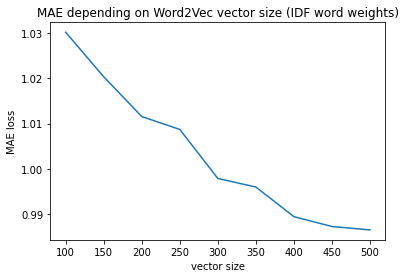

In [ ]:
%%time

# positive и negative части отзывов объединены
vector_size_range = list(range(100, 501, 50))
mae_log = []
for vector_size in vector_size_range:
    w2v_model_united = Word2Vec(sentences=[x.split() for x in df_train['united']], size=vector_size, window=10, workers=4)
    lr_model = Ridge()
    lr_model.fit(get_embeddings_united_idf(X_train, wv2_model_united), y_train)
    mae = mean_absolute_error(lr_model.predict(get_embeddings_united_idf(X_test, w2v_model_united)), y_test)
    mae_log.append(mae)

plt.plot(vector_size_range, mae_log)
plt.title('MAE depending on Word2Vec vector size (IDF word weights)')
plt.ylabel('MAE loss')
plt.xlabel('vector size');

Wall time: 2min 49s


Text(0.5, 0, 'vector size')

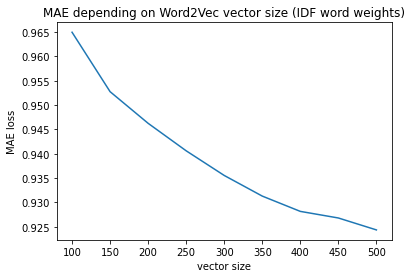

In [ ]:
%%time

# positive и negative части отзывов рассматриваются отдельно
vector_size_range = list(range(100, 501, 50))
mae_log = []
for vector_size in vector_size_range:
    w2v_model_separate = Word2Vec(sentences=[x.split() for x in df_train_separate], size=vector_size, window=10, workers=4)
    lr_model = Ridge()
    lr_model.fit(get_embeddings_separate_idf(X_train, wv2_model_separate), y_train)
    mae = mean_absolute_error(lr_model.predict(get_embeddings_separate_idf(X_test, w2v_model_separate)), y_test)
    mae_log.append(mae)

plt.plot(vector_size_range, mae_log)
plt.title('MAE depending on Word2Vec vector size (IDF word weights)')
plt.ylabel('MAE loss')
plt.xlabel('vector size');

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:
Для каждого из двух методов с увеличением размерности эмбеддинга ошибка уменьшается.

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы:
Модель, обученная на эмбеддингах FastText, дает схожие результаты с моделью, обученной на эмбеддингах Word2Vec.

In [ ]:
ft_model_separate = FastText(sentences=[x.split() for x in df_train_separate], size=300, window=10, workers=4)

In [ ]:
%%time

lr_model = Ridge()
lr_model.fit(get_embeddings_separate(X_train, ft_model_separate, fasttext_model=True), y_train)
print(mean_absolute_error(lr_model.predict(get_embeddings_separate(X_test, ft_model_separate, fasttext_model=True)), y_test))

0.9327306785283679
Wall time: 14.7 s


### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/ИАД — Современные методы машинного обучения/hw3/train_reviews.csv'

In [3]:
nn_df = pd.read_csv(csv_path, index_col=[0]).fillna('')
nn_df['negative'] = nn_df['negative'].apply(lambda x: x.split())
nn_df['positive'] = nn_df['positive'].apply(lambda x: x.split())
nn_df

,negative,positive,score,united
0,"[there, be, issue, with, the, wifi, connection]",[],7.1,there be issue with the wifi connection
1,"[tv, not, work]",[],7.5,tv not work
2,"[more, pillow]","[beautiful, room, great, location, lovely, staff]",10.0,more pillow beautiful room great location love...
3,"[very, business]",[location],5.4,very business location
4,"[room, could, do, with, a, bit, of, a, refurbi...","[nice, breakfast, handy, for, victoria, train,...",6.7,room could do with a bit of a refurbishment as...
...,...,...,...,...
99995,"[no, coffee, facility, in, room, air, con, did...","[very, quiet, for, a, central, london, hotel, ...",7.9,no coffee facility in room air con didn t seem...
99996,"[the, room, be, far, too, hot, on, the, first,...","[breakfast, be, fine, welcome, with, cava, be,...",4.2,the room be far too hot on the first night 28 ...
99997,"[terrible, wear, out, mattress, dust, behind, ...","[the, well, meaning, staff]",5.0,terrible wear out mattress dust behind the hea...
99998,[],"[very, profissional, and, nice, staff, very, w...",9.6,very profissional and nice staff very well de...


In [83]:
nn_df_separate = pd.concat([nn_df['negative'], nn_df['positive']], axis=0)
nn_df_separate

0          [there, be, issue, with, the, wifi, connection]
1                                          [tv, not, work]
2                                           [more, pillow]
3                                         [very, business]
4        [room, could, do, with, a, bit, of, a, refurbi...
                               ...                        
99995    [very, quiet, for, a, central, london, hotel, ...
99996    [breakfast, be, fine, welcome, with, cava, be,...
99997                          [the, well, meaning, staff]
99998    [very, profissional, and, nice, staff, very, w...
99999    [great, breakfast, and, the, room, be, clean, ...
Length: 200000, dtype: object

In [4]:
WORDS = set()
for sent in list(nn_df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(nn_df['negative']):
    for w in sent:
        WORDS.add(w)

In [5]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [6]:
print(nn_df['negative'].apply(len).quantile(0.95))
print(nn_df['positive'].apply(len).quantile(0.95))

67.0
54.0


In [110]:
# MAX_LEN = max(max(nn_df['positive'].apply(len)), max(nn_df['negative'].apply(len)))
MAX_LEN = 70

In [111]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.negative_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN], dtype=torch.long) for seq in df['negative']], 
                            batch_first=True)
        self.positive_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN], dtype=torch.long) for seq in df['positive']], 
                            batch_first=True)
        self.pad = torch.hstack([self.negative_pad, self.positive_pad])
        self.scores = df['score']
        
    def __len__(self):
        return len(self.pad)
    
    def __getitem__(self, idx):
        return self.pad[idx], torch.Tensor([self.scores.iloc[idx]])

In [112]:
BATCH_SIZE = 64

reviews_dataset = ReviewsDataset(nn_df)
train_subset, test_subset = random_split(ReviewsDataset(nn_df), [75000, 25000], generator=torch.Generator().manual_seed(42))

train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, drop_last=True)

In [113]:
class WordRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                    n_pad=MAX_LEN * 2, embed_dim=300, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.embed_dim = embed_dim
        self.lr = lr
        
        # creating character dictionaries
        self.WORDS = tokens
        self.int2word = dict(enumerate(self.WORDS))
        self.word2int = {ch: ii for ii, ch in self.int2word.items()}
        self.vocab_size = len(self.word2int)
        
        # define the embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(embed_dim,
                            n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden * n_pad, 1)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        # Get embeddings
        embed = self.embedding(x)
        
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_out, hidden = self.lstm(embed, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_out)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(out.shape[0], -1)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [107]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [52]:
def train(net, train_dataloader, test_dataloader, epochs=10, lr=0.001, clip=5, val_frac=0.1, print_every=50, plot_every=500):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    batch_size = train_dataloader.batch_size
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.L1Loss()
    
    if(train_on_gpu):
        net.cuda()
    
    train_loss_log = []
    val_loss_log = []

    counter = 0
    n_words = len(net.WORDS)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for inputs, targets in train_dataloader:
            counter += 1
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            # save loss log
            train_loss_log.append(loss.item())
            
            # print train loss
            if counter % print_every == 0:    
                print("Epoch: {}/{}...".format(e+1, epochs),
                        "Step: {}...".format(counter),
                        "Loss: {:.4f}...".format(loss.item()))
                
            # start validation
            if counter % plot_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for inputs, targets in test_dataloader:
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()
                    output, val_h = net(inputs, val_h)

                    val_loss = criterion(output, targets)
                
                    val_losses.append(val_loss.item())
                val_loss_mean = np.mean(val_losses)
                # save val loss
                val_loss_log.append(val_loss_mean)
                
                net.train() # reset to train mode after iterationg through validation data
                
                # print and plot val loss
                clear_output()
                print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.4f}...".format(loss.item()),
                    "Val Loss: {:.4f}".format(val_loss_mean))

                plot_history(train_loss_log, val_loss_log, 'loss')

In [115]:
# define and print the net
n_hidden=512
n_layers=3
embed_dim = 300

net = WordRNN(WORDS, n_hidden, n_layers, embed_dim=embed_dim)
print(net)

WordRNN(
  (embedding): Embedding(29965, 300)
  (lstm): LSTM(300, 512, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=71680, out_features=1, bias=True)
)


In [13]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


Epoch: 3/10... Step: 2500... Loss: 0.6720... Val Loss: 0.7861


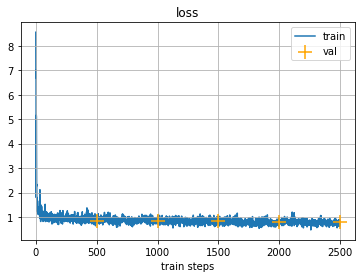

Epoch: 3/10... Step: 2550... Loss: 0.7306...
Epoch: 3/10... Step: 2600... Loss: 0.9593...


KeyboardInterrupt: ignored

In [116]:
train(net, train_dataloader, test_dataloader)

LSTM дает ошибку на валидации 0.78, что меньше, чем во всех вышеперечисленных методах.

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.

In [ ]:
df_kaggle = pd.read_csv('hseds-texts-2020/test.csv')
df_kaggle

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...
3,000a66d32bcf305148d789ac156dd512,Noisy various electrical devices kicking in r...,Great location Nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,No Negative,Great location and friendly staff
...,...,...,...
19995,ffe8a7190aee6e3a53ee2e0145a91555,Check in Staff not consistant with comments e...,No Positive
19996,ffea0e2b84788c9df755efe8e2bedb23,better lift access to top floor bathrooms a l...,Great location on the Piccadilly Line so easy...
19997,fff3997a85a1eed7ae7a937bc945fcf0,To add a gym and a pool Then It would be perf...,Great location very nice design great breakfa...
19998,fff673fe95ab8f3a0910f112549862e2,Room was a bit noisy you can hear cars and th...,The entrance area looks great and the ground ...


In [ ]:
%%time

df_kaggle['negative'] = df_kaggle['negative'].apply(process_text)
df_kaggle['positive'] = df_kaggle['positive'].apply(process_text)

df_kaggle['negative'] = df_kaggle['negative'].apply(lambda x: '' if x == 'no negative' else x)
df_kaggle['positive'] = df_kaggle['positive'].apply(lambda x: '' if x == 'no positive' else x)

df_kaggle['united'] = df_kaggle['negative'] + ' ' + df_kaggle['positive']

Wall time: 1min 10s


In [ ]:
df_kaggle

,review_id,negative,positive,united
0,00026f564b258ad5159aab07c357c4ca,other than the location everything else be hor...,just the location,other than the location everything else be hor...
1,000278c73da08f4fcb857fcfe4ac6417,no uk tv but this be a minor point as -PRON- b...,great location very comfortable clean breakfas...,no uk tv but this be a minor point as -PRON- b...
2,000404f843e756fe3b2a477dbefa5bd4,a tiny noisy room very deceptively photograph,the breakfast book the precede night but forgo...,a tiny noisy room very deceptively photograph ...
3,000a66d32bcf305148d789ac156dd512,noisy various electrical device kick in random...,great location nice bathroom,noisy various electrical device kick in random...
4,000bf1d8c5110701f459ffbedbf0d546,,great location and friendly staff,great location and friendly staff
...,...,...,...,...
19995,ffe8a7190aee6e3a53ee2e0145a91555,check in staff not consistant with comment eg ...,,check in staff not consistant with comment eg ...
19996,ffea0e2b84788c9df755efe8e2bedb23,well lift access to top floor bathroom a littl...,great location on the piccadilly line so easy ...,well lift access to top floor bathroom a littl...
19997,fff3997a85a1eed7ae7a937bc945fcf0,to add a gym and a pool then -PRON- would be p...,great location very nice design great breakfas...,to add a gym and a pool then -PRON- would be p...
19998,fff673fe95ab8f3a0910f112549862e2,room be a bit noisy -PRON- can hear car and th...,the entrance area look great and the ground fl...,room be a bit noisy -PRON- can hear car and th...


In [ ]:
%%time

# positive и negative части отзывов рассматриваются отдельно
lr_model = Ridge()
lr_model.fit(get_bow_separate(X_train), y_train)
kaggle_pred = lr_model.predict(get_bow_separate(df_kaggle))

Wall time: 2.58 s


In [ ]:
df_kaggle_pred = pd.DataFrame({'review_id': df_kaggle['review_id'], 'score': kaggle_pred})
df_kaggle_pred = df_kaggle_pred.set_index('review_id')

In [ ]:
df_kaggle_pred.to_csv('kaggle_pred.csv')